# Imports
The following imports below are vital as they will allow for the code to run correctly. The frameworks Keras and Tensorflow are used for building the neural network and training it.

# Fine-tuning of the InceptionV3 model
A pretrained model is being used which is the InceptionV3 model, meaning that it is already trained on a dataset such as ImageNet. By fine-tuning it, a couple of aspects are changed to improve it's performance.


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  9 14:47:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
import pathlib

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import pathlib
import numpy as np

import os
from collections import defaultdict
from shutil import copy

import pandas as pd
import tensorflow as tf

import pathlib
import numpy as np
import requests
import tarfile

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

def download_data_set(url: str) -> None:

    name = pathlib.Path(url).name.replace('.tar.gz', '')
    directory = pathlib.Path(name)

    if directory.exists():
        print(f'Skipping download of {name} as directory already exists')
    else:
        print(f'Directory {name} not found. Downloading...')
        response = requests.get(url, stream=True)
        file = tarfile.open(fileobj=response.raw, mode="r|gz")
        file.extractall(path=".")
        print('Download complete!')
    

def get_image_previews():

    data_dir = pathlib.Path("food-101/images/")
    food_directories = sorted(data_dir.glob('*'))

    images = []
    for food_directory in food_directories:
        directory_images = list(food_directory.glob('*.jpg'))
        if not directory_images:
            continue
        
        random_food = np.random.choice(directory_images)
        images.append(random_food)

    shape = (17, 6)
    (rows, cols) = shape
    while len(images) < (rows * cols):
        images.append(None)

    image_array = np.array(images)
    return image_array.reshape(shape)

def plot_images(image_array):

    import matplotlib.pyplot as plt

    (rows, cols) = image_array.shape
    fig, ax = plt.subplots(rows, cols, figsize=(15,40))
    fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) 

    for i in range(rows):
        for j in range(cols):
            image_path = image_array[i][j]
            if not image_path:
                continue

            food_type = image_path.parent.name
            img = plt.imread(image_path)
            ax[i][j].imshow(img)
            ax[i][j].set_title(food_type, pad = 10)

    plt.setp(ax, xticks=[],yticks=[])
    plt.tight_layout()
    plt.show()


def get_images_df(category: str):

    filepath = f'food-101/meta/{category}.txt'
    
    image_by_food_type = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]


    for image_path in paths:
        path = pathlib.Path(image_path)
        food_type = path.parent.name
        full_image_path = f'{"food-101" / ("images" / path)}.jpg'
        image_by_food_type[food_type].append(full_image_path)
    
    df = pd.DataFrame(data=image_by_food_type)
    df = df.melt(var_name='class', value_name='filename')
    df['class'] = df['class'].astype('category')
    return df


def train_model(n_classes, num_epochs, train_images_df, test_images_df):

    clear_session()
    root = os.getcwd()

    img_size = (299, 299)
    batch_size = 16

    best_model_path = f'bestmodel_{n_classes}class.hdf5'
    trained_model_path = f'trainedmodel_{n_classes}class.hdf5'
    history_path = f'history_{n_classes}.log'

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_images_df, 
        directory=root,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical')

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    validation_generator = test_datagen.flow_from_dataframe(
        test_images_df, 
        directory=root,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical')


    inception = InceptionV3(weights='imagenet', include_top=False)
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

    model = Model(inputs=inception.input, outputs=predictions)
    optimizer = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(filepath=best_model_path, verbose=1, save_best_only=True)
    csv_logger = CSVLogger(history_path)

    nb_train_samples = len(train_images_df)
    nb_test_samples = len(test_images_df)

    history = model.fit(train_generator,
        steps_per_epoch = nb_train_samples // batch_size,
        validation_data=validation_generator,
        validation_steps=nb_test_samples // batch_size,
        epochs=num_epochs,
        verbose=1,
        callbacks=[csv_logger, checkpoint])

    model.save(trained_model_path)
    class_map = train_generator.class_indices
    return history, class_map


tensor_flow_version = tf.__version__
gpu_device_name = tf.test.gpu_device_name()
print(f'Tensor flow version = {tensor_flow_version}')
print(f'GPU device name = {gpu_device_name}')


Tensor flow version = 2.8.0
GPU device name = /device:GPU:0


# Downloading the Food-101 dataset
The dataset that is used for the food classification is the Food-101 dataset available at http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz. As the name implies, the dataset has 101 classes of food and each class contains 1000 images amounting to 101,000 images. This will allow for multiclass classification. The data is organised so that there are 750 images for training and 250 images for testing within each class.

In [17]:
# Downloading the data set
url = r'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
download_data_set(url)

Skipping download of food-101 as directory already exists


# Import Calorie and Carbon Footprint data

In [18]:
food_data = pd.read_csv('/content/Food101Calories_CarbonFootprint.csv', index_col='food')
food_data.drop(labels=['index'], axis=1, inplace=True)
food_data.head(5)

,carbon footprint - emissions (gCO2e) per 100 g,Calories (kcal) per 100g
food,,
apple_pie,158,237
baby_back_ribs,3441,275
baklava,453,408
beef_carpaccio,2426,231
beef_tartare,1774,246


# Visualising the Food-101 dataset

In [19]:
%matplotlib inline

# Create a grid of image filepaths
#image_array = get_image_previews()
#plot_images(image_array)

# Create a Dataframe of the Test/Train metadata

In [20]:
train_images_df = get_images_df('train')
test_images_df = get_images_df('test')

pd.DataFrame(data={
    'Category': ['Train', 'Test'],
    'Count': [len(train_images_df), len(test_images_df)]
})

test_images_df.sample(10) 

,class,filename
682,baklava,food-101/images/baklava/3517946.jpg
14966,lasagna,food-101/images/lasagna/499765.jpg
19397,pork_chop,food-101/images/pork_chop/2945702.jpg
19030,pizza,food-101/images/pizza/139952.jpg
2163,bread_pudding,food-101/images/bread_pudding/3272673.jpg
4000,cheesecake,food-101/images/cheesecake/1023543.jpg
20988,red_velvet_cake,food-101/images/red_velvet_cake/851600.jpg
9864,foie_gras,food-101/images/foie_gras/2641571.jpg
9174,falafel,food-101/images/falafel/3487328.jpg
10729,french_toast,food-101/images/french_toast/791313.jpg


# Data Summary
 - Filter existing dataframes to make the initial datasets smaller.
 - We only include food classes that are part of the `mini_food_list`
 - Summarise the size of the filtered dataframes

In [21]:
#mini_food_list = {'apple_pie','pizza'}
NUM_MINI_CLASSES = 5
mini_food_list = train_images_df["class"].unique()[:NUM_MINI_CLASSES] # train for first 'x' no. of classes
#mini_food_list = train_images_df["class"].unique() # train for all classes

mini_train_images_df = train_images_df[train_images_df['class'].isin(mini_food_list)].copy()
mini_test_images_df = test_images_df[test_images_df['class'].isin(mini_food_list)].copy()

pd.DataFrame(data={
    'Category': ['Train', 'Test'],
    'Count': [len(mini_train_images_df), len(mini_test_images_df)]
})

mini_test_images_df.sample(10) 

,class,filename
140,apple_pie,food-101/images/apple_pie/2983047.jpg
11,apple_pie,food-101/images/apple_pie/1167170.jpg
369,baby_back_ribs,food-101/images/baby_back_ribs/2587414.jpg
917,beef_carpaccio,food-101/images/beef_carpaccio/3187459.jpg
362,baby_back_ribs,food-101/images/baby_back_ribs/2454123.jpg
385,baby_back_ribs,food-101/images/baby_back_ribs/2733895.jpg
677,baklava,food-101/images/baklava/3480784.jpg
700,baklava,food-101/images/baklava/3753309.jpg
825,beef_carpaccio,food-101/images/beef_carpaccio/1937269.jpg
1218,beef_tartare,food-101/images/beef_tartare/525546.jpg


In [ ]:
#mini_food_list = train_images_df["class"].unique()

# Training the InceptionV3 model

In [22]:
# Train the model
num_epochs = 6
num_classes = len(mini_food_list)

history, class_indices = train_model(
  num_classes,
  num_epochs,
  mini_train_images_df,
  mini_test_images_df)

print(class_indices)

Found 3750 validated image filenames belonging to 5 classes.
Found 1250 validated image filenames belonging to 5 classes.
Epoch 1/6
234/234 [==============================] - ETA: 0s - loss: 1.5224 - accuracy: 0.3790
Epoch 1: val_loss improved from inf to 1.25825, saving model to bestmodel_5class.hdf5
234/234 [==============================] - 101s 408ms/step - loss: 1.5224 - accuracy: 0.3790 - val_loss: 1.2582 - val_accuracy: 0.6290
Epoch 2/6
234/234 [==============================] - ETA: 0s - loss: 1.1651 - accuracy: 0.6119
Epoch 2: val_loss improved from 1.25825 to 0.87926, saving model to bestmodel_5class.hdf5
234/234 [==============================] - 93s 398ms/step - loss: 1.1651 - accuracy: 0.6119 - val_loss: 0.8793 - val_accuracy: 0.7700
Epoch 3/6
234/234 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.7268
Epoch 3: val_loss improved from 0.87926 to 0.63516, saving model to bestmodel_5class.hdf5
234/234 [==============================] - 93s 396ms/step 

In [23]:
K.clear_session()
best_model_path = f"bestmodel_{num_classes}class.hdf5"
pretrained_model = load_model(best_model_path, compile = False)
pretrained_model

In [24]:
reverse_class_indices = {v: k for k, v in class_indices.items()}
reverse_class_indices

{0: 'apple_pie',
 1: 'baby_back_ribs',
 2: 'baklava',
 3: 'beef_carpaccio',
 4: 'beef_tartare'}

In [25]:
def get_prediction(image_path: str) -> int:
    img = image.load_img(image_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    pred_vector = pretrained_model.predict(img)
    pred_index = np.argmax(pred_vector)
    return pred_index

mini_test_images_df["y_test"] = mini_test_images_df["class"].map(class_indices).astype(int)
mini_test_images_df["y_pred"] = mini_test_images_df["filename"].map(get_prediction)
mini_test_images_df["class_pred"] = mini_test_images_df["y_pred"].map(reverse_class_indices)
mini_test_images_df = mini_test_images_df[['filename', 'class', 'class_pred', 'y_test', 'y_pred']]
mini_test_images_df

,filename,class,class_pred,y_test,y_pred
0,food-101/images/apple_pie/1011328.jpg,apple_pie,apple_pie,0,0
1,food-101/images/apple_pie/101251.jpg,apple_pie,apple_pie,0,0
2,food-101/images/apple_pie/1034399.jpg,apple_pie,baklava,0,2
3,food-101/images/apple_pie/103801.jpg,apple_pie,apple_pie,0,0
4,food-101/images/apple_pie/1038694.jpg,apple_pie,apple_pie,0,0
...,...,...,...,...,...
1245,food-101/images/beef_tartare/926143.jpg,beef_tartare,beef_tartare,4,4
1246,food-101/images/beef_tartare/948352.jpg,beef_tartare,beef_tartare,4,4
1247,food-101/images/beef_tartare/956509.jpg,beef_tartare,beef_tartare,4,4
1248,food-101/images/beef_tartare/976175.jpg,beef_tartare,beef_tartare,4,4


# Confusion Matrix

Confusion matrix, without normalization


,apple_pie,baby_back_ribs,baklava,beef_carpaccio,beef_tartare
apple_pie,212,2,30,0,6
baby_back_ribs,1,245,0,0,4
baklava,32,3,212,2,1
beef_carpaccio,7,5,0,220,18
beef_tartare,8,7,1,8,226


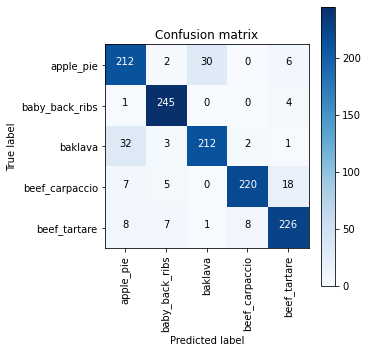

In [26]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return pd.DataFrame(data=confusion_matrix, columns=classes, index=classes)

y_test = mini_test_images_df["y_test"]
y_pred = mini_test_images_df["y_pred"]
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred).numpy()
confusion_matrix

classes = [v for (k,v) in sorted(reverse_class_indices.items())] 

plt.figure()
fig = plt.gcf()
fig.set_size_inches(5,5)
#plot_confusion_matrix(confusion_matrix, classes, True) # Normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, False)



# Generate accuracy and loss plots
This allows for a visualisation of the model's accuracy and loss as the amount of epochs were used to train it increased

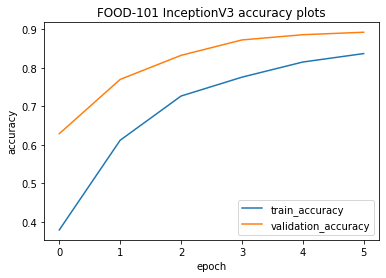

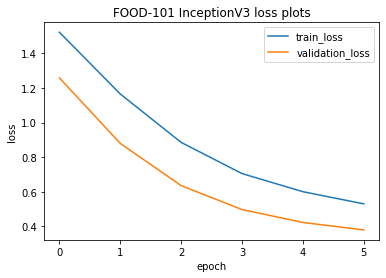

In [28]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) 
    plt.plot(history.history['val_accuracy']) 
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

plot_accuracy(history,'FOOD-101 InceptionV3 accuracy plots')
plot_loss(history,'FOOD-101 InceptionV3 loss plots')

In [29]:
def get_data_on_food(food_class):
  row = food_data[food_data.index == food_class].iloc[0, :]
  carbon_footprint = row[0]
  calories = row[1]
  return calories, carbon_footprint

get_data_on_food('french_fries')

(274, 382)

# Classification

In [30]:
def classify_and_give_info(food_type):
  print(f'Select random image for {food_type} and show summary')
  is_food_type = mini_test_images_df["class"] == food_type
  filtered_table = mini_test_images_df[is_food_type]
  random_row = filtered_table.sample(1).iloc[0, :]

  image_path = random_row[0]
  class_actual = random_row[1]
  class_pred = random_row[2]

  fig, ax = plt.subplots(1, 1, figsize=(5,5))
  fig.suptitle("Random image from the selected class", y=1.05, fontsize=24) 


  img = plt.imread(image_path)
  ax.imshow(img)
  ax.set_title(food_type, pad = 10)

  plt.setp(ax, xticks=[],yticks=[])
  plt.tight_layout()
  plt.show()

  actual_calories, actual_footprint = get_data_on_food(class_actual)
  pred_calories, pred_footprint = get_data_on_food(class_pred)

  results = {
      'Food Type': [class_actual, class_pred],
      'Calories': [actual_calories, pred_calories],
      'Carbon Footprint': [actual_footprint, pred_footprint]
  }

  results_df = pd.DataFrame(data=results, index=['Actual', 'Predicted'])

  return results_df

from ipywidgets import interact
_ = interact(classify_and_give_info, food_type=mini_food_list)

interactive(children=(Dropdown(description='food_type', options=('apple_pie', 'baby_back_ribs', 'baklava', 'be…

# Accuracy by Class

Text(0.5, 1.0, 'Histogram Showing the Accuracy by Food Class')

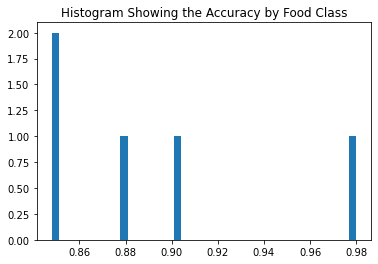

In [31]:
diag = np.diagonal(confusion_matrix)
counts = np.sum(confusion_matrix, axis=1)
accuracy = diag / counts
accuracy

plt.hist(accuracy, bins=40)
plt.title('Histogram Showing the Accuracy by Food Class')

In [32]:
sorted_class_accuracies = sorted(accuracy, key=lambda x: -x[1])
[(class_map[c[0]], c[1]) for c in sorted_class_accuracies]

IndexError: ignored